In [1]:
import tensorflow as tf

import tensorflow.keras
from tensorflow.keras.layers import Lambda, Input, Dense, Conv2D, Flatten, Conv2DTranspose, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras import backend as K

from process_data import load_train_data, process_daq, sub_train_test, sub_split
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sVAE_utils import sampling, plot_results, build_vae, eval_vae

import numpy as np
import matplotlib.pyplot as plt
import os
from gpu import set_gpu

set_gpu()

Num GPUs Available:  1


In [2]:
# Load raw EMG data
feat,params,daq = load_train_data('train_data_raw_AB.mat')
raw = process_daq(daq,params)

# Reshape data for CNN architecture
raw = raw[::2,:,:].transpose(2,1,0)
feat_sq = feat.reshape(feat.shape[0],6,10)

In [3]:
# Index EMG data
sub = 14
train_grp = 2
test_grp = 3
x_train, y_train, x_test, y_test = sub_train_test(raw,params,sub,train_grp,test_grp)

# Shuffle and split data
# x_train, x_test, y_train, y_test = train_test_split(feat_sq_s, label_sq_s, test_size=0.3, random_state=0, stratify=label_sq_s)

In [4]:
# Scale data
scaler = MinMaxScaler(feature_range=(-1,1))
x_train = scaler.fit_transform(x_train.reshape(x_train.shape[0],-1)).reshape(x_train.shape)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

In [5]:
batch_size = 64
latent_dim = 10
epochs = 100

vae, encoder, decoder, clf = build_vae(latent_dim, input_type='raw')

In [6]:
vae.fit(x_train, {'clf': y_train},epochs=epochs,batch_size=batch_size)
vae.save_weights('vae_raw.h5')

Epoch 1/100
55/55 [==============================] - 1s 12ms/step - loss: 2.1998 - clf_loss: 1.9907
Epoch 2/100
55/55 [==============================] - 1s 10ms/step - loss: 1.8138 - clf_loss: 1.5244
Epoch 3/100
55/55 [==============================] - 0s 9ms/step - loss: 1.3639 - clf_loss: 0.9965
Epoch 4/100
55/55 [==============================] - 0s 9ms/step - loss: 1.1698 - clf_loss: 0.8223
Epoch 5/100
55/55 [==============================] - 0s 9ms/step - loss: 1.0640 - clf_loss: 0.7268
Epoch 6/100
55/55 [==============================] - 0s 9ms/step - loss: 0.9556 - clf_loss: 0.6198
Epoch 7/100
55/55 [==============================] - 0s 9ms/step - loss: 0.8744 - clf_loss: 0.5420
Epoch 8/100
55/55 [==============================] - 0s 9ms/step - loss: 0.8056 - clf_loss: 0.4720
Epoch 9/100
55/55 [==============================] - 0s 9ms/step - loss: 0.7338 - clf_loss: 0.4042
Epoch 10/100
55/55 [==============================] - 0s 9ms/step - loss: 0.7010 - clf_loss: 0.3731
Epoch 1

In [9]:
test_grp = 2
x_test, y_test = sub_split(raw, params, sub, test_grp)
x_test = scaler.transform(x_test.reshape(x_test.shape[0],-1)).reshape(x_test.shape)

y_pred, acc = eval_vae(vae, x_test, y_test)
print(acc)

models = (encoder, decoder)
data = (x_test, np.argmax(y_test, axis=1))

0.9991428571428571


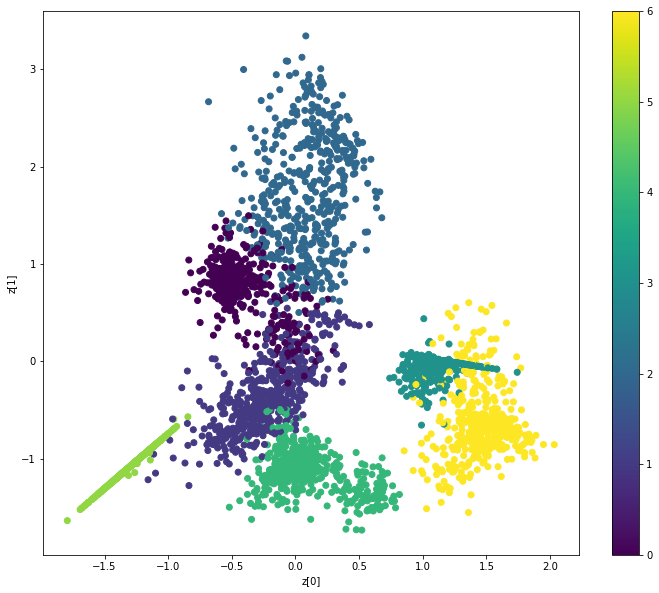

In [10]:
plot_results(models,
                data,
                batch_size=batch_size,
                model_name="vae_mlp")

In [12]:
from lda import train_lda, predict

# Shuffle and split data
# feat_s, label_s = shuffle(feat[ind,:],params[ind,-2,np.newaxis])
# x_train_lda = feat_s
# y_train_lda = label_s-1
x_train_lda, y_train_lda, x_test_lda, y_test_lda = sub_train_test(feat, params, sub, train_grp, test_grp)
# x_train, _, y_train, _ = train_test_split(x_feats, y_feats, test_size=0.3, random_state=0, stratify=label_s)

w,c = train_lda(x_train_lda,y_train_lda)

In [13]:
test_grp = 6
x_test_lda, y_test_lda = sub_split(feat, params, sub, test_grp)
out = predict(x_test_lda,w,c)
np.sum(out.reshape(y_test_lda.shape) == y_test_lda)/y_test_lda.shape[0]

0.6697142857142857